<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Librerías" data-toc-modified-id="Librerías-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Librerías</a></span></li><li><span><a href="#Data-Loading" data-toc-modified-id="Data-Loading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Loading</a></span></li><li><span><a href="#Pre-Procesamiento" data-toc-modified-id="Pre-Procesamiento-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-Procesamiento</a></span></li><li><span><a href="#Train-y-Test" data-toc-modified-id="Train-y-Test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train y Test</a></span></li><li><span><a href="#Matrix-TF-idf" data-toc-modified-id="Matrix-TF-idf-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Matrix TF-idf</a></span></li><li><span><a href="#Modelamiento" data-toc-modified-id="Modelamiento-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Modelamiento</a></span><ul class="toc-item"><li><span><a href="#Modelo-Naive-Bayes" data-toc-modified-id="Modelo-Naive-Bayes-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Modelo Naive Bayes</a></span><ul class="toc-item"><li><span><a href="#Dataset-SnowBall-Stemmer" data-toc-modified-id="Dataset-SnowBall-Stemmer-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Dataset SnowBall Stemmer</a></span></li><li><span><a href="#Dataset-Word-Net-Lemmatizer" data-toc-modified-id="Dataset-Word-Net-Lemmatizer-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Dataset Word Net Lemmatizer</a></span></li></ul></li><li><span><a href="#Modelo-SVM" data-toc-modified-id="Modelo-SVM-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Modelo SVM</a></span><ul class="toc-item"><li><span><a href="#Dataset-SnowBall-Stemmer" data-toc-modified-id="Dataset-SnowBall-Stemmer-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Dataset SnowBall Stemmer</a></span></li><li><span><a href="#Dataset-Word-Net-Lemmatizer" data-toc-modified-id="Dataset-Word-Net-Lemmatizer-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Dataset Word Net Lemmatizer</a></span></li></ul></li></ul></li><li><span><a href="#Resultados" data-toc-modified-id="Resultados-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Resultados</a></span></li></ul></div>

# Práctica 2: Clasificación de Textos

* Curso: Data Science para la Gestión de la Información no Estructurada
* Nombre: Mayra Johana Goicochea Neyra
* Máster en Data Science para Finanzas

## Librerías
Primer paso es importar las librerias necesarias: 
* `pandas` y `numpy` son utilizadas para la carga y procesamiento del archivo csv.
* La libreria `nltk` y sus derivados como tokenize, corpus y stem son utilizados para procesar los elementos de textos del archivo.
* La libreria `sklearn` contiene los algoritmos para los modelos de clasificación.

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

Además, se define el número de semilla para que la etapa de split de las muestras de entrenamiento y evaluación como también la construcción de modelos sea replicable.
Se determina también que el Stemmer seráen español.

In [5]:
#Set Random seed
np.random.seed(387)

#Snowball Stemmer
ss = SnowballStemmer('spanish')

## Data Loading


A continuación se carga los elementos del archivo `hotel.csv` mediante pandas.read_csv. Se estableció `utf-8` como el modo de codificación debido a que las tildes eran definidas adecuadamente mediante ese método.

In [6]:
Hotel = pd.read_csv(r"hotel.csv",encoding='utf-8')

In [7]:
Hotel.head()

,text,label
0,Es un gran hotel; el mejor de Asunción. Buenas...,3
1,hola. no suelo criticar jamas lo que paso pero...,3
2,Escogi meses antes de mi boda una habitacion p...,3
3,Voy a se Lo mas equitativo posible; porque soy...,3
4,Esta es una experiencia de septiembre de 2016;...,3


## Pre-Procesamiento
Esta etapa consiste en las actividades de limpieza y adecuación de la información para proceder con el modelado. Para ello se utilizó la librería `nltk`
* Primero se eliminan los elementos en blanco.
* Se eliminan los cáracteres especiales mediante la libreria `re`.
* Se transforman los textos en minusculas.
* Se separa los textos en palabras.
* Como último paso, se eliminan los stop-words y se extraen las formas canónicas en dos maneras, una mediante WordNetLemmatizer y la otra a través de SnowBall Stemmer. Se guardan estas dos formas canónicas en dos columnas del dataframe.

In [8]:
# Paso - 1a : Elimimamos lineas vacías.
Hotel['text'].dropna(inplace=True)

In [9]:
Hotel['text']=[re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) for doc in Hotel['text']]

In [10]:
# Paso - 1b : Conversión a minúsculas
Hotel['text'] = [entry.lower().strip() for entry in Hotel['text']]

In [11]:
# Paso - 1c : Tokenization
Hotel['text']= [word_tokenize(entry) for entry in Hotel['text']]

In [12]:
# Paso - 1d : Eliminamos Stop words, Stemming y Lematización.
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [13]:
for index,entry in enumerate(Hotel['text']):
    # Inicialización de Final_words vacía
    Final_words_s = []
    Final_words_w = []
    # Inicializacion de WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag
    for word, tag in pos_tag(entry):
        # Eliminamos Stop words y caracteres no alfabéticos
        if word not in stopwords.words('spanish') and word.isalpha():
            word_Final_w = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            word_Final_s = ss.stem(word)
            Final_words_s.append(word_Final_s)
            Final_words_w.append(word_Final_w)
    # El texto preprocesado se almacena en 'text_final'
    Hotel.loc[index,'final_WNL'] = str(Final_words_w)
    Hotel.loc[index,'final_SNB'] = str(Final_words_s)
print(Hotel['final_WNL'].head())

0    ['gran', 'hotel', 'mejor', 'asuncin', 'buenas'...
1    ['hola', 'suelo', 'criticar', 'jamas', 'paso',...
2    ['escogi', 'me', 'boda', 'habitacion', 'hacer'...
3    ['voy', 'ma', 'equitativo', 'posible', 'person...
4    ['experiencia', 'septiembre', 'asi', 'quizas',...
Name: final_WNL, dtype: object


In [14]:
print(Hotel['final_SNB'].head())

0    ['gran', 'hotel', 'mejor', 'asuncin', 'buen', ...
1    ['hol', 'suel', 'critic', 'jam', 'pas', 'vez',...
2    ['escogi', 'mes', 'bod', 'habitacion', 'hac', ...
3    ['voy', 'mas', 'equit', 'posibl', 'person', 'b...
4    ['experient', 'septiembr', 'asi', 'quiz', 'cos...
Name: final_SNB, dtype: object


## Train y Test
La información se divide en dos muestras, una para entrenar los modelos y la otra muestra para evaluar los modelos, y concluir los resultados óptimos para los datos.

En este caso, he divido en dos muestras de entrenamiento, una para probar los modelos con las palabras reducidas con Word Net Lemmatizer y la otra con Snowball Stemmer. Lo mismo, lo realice con las muestras de evaluación.

In [15]:
Hotel['label'].value_counts(normalize=True)

3    0.555
5    0.445
Name: label, dtype: float64

Para mantener la proporción de los casos con valor 3 y 5, utilice la propiedad `stratify`.

In [16]:
# División en conjunto de entrenamiento y test
Train_X_SB, Test_X_SB,Train_X_WN, Test_X_WN, Train_Y, Test_Y = model_selection.train_test_split(Hotel['final_SNB'],
                                                                                                Hotel['final_WNL'],
                                                                                                Hotel['label'],test_size=0.3, stratify=Hotel['label'])

In [17]:
Train_Y.value_counts(normalize=True)

3    0.557143
5    0.442857
Name: label, dtype: float64

In [18]:
Test_Y.value_counts(normalize=True)

3    0.55
5    0.45
Name: label, dtype: float64

## Matrix TF-idf
El siguiente paso previo al modelamiento, es convertir los valores de los label en numéricos, donde 3 es considerado como 0 y 5 como 1.
Luego se vectoriza los valores de las muestras train_X y test_X en matrices Tf-idf, este modelo asigna pesos a las palabras basadas en dos estimadores: Tf, que representa la frecuencia de la palabra o elemento en el documento (que se considera la fila o texto del dataframe) e idf que mide si el termino es común en la colección de documentos. Por ejemplo, en este caso se toma la frecuencia de la palabra `acceso` dentro de la lista del primer elemento del dataframe y se multiplica por la medida inversa de frecuencia que tiene ese termino en todas las listas de este dataframe (si es muy común se accerca al valor 0).

In [19]:
# Codificación de etiquetas (categorías)
# Las categorías tienen una etiqueta tipo string, pero los algoritmos de clasifiación necesitan un valor numérico
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [20]:
Train_Y

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [21]:
Test_Y

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

Se crea 4 vectores Tfidf para entrenamiento y evaluación de las muestras reducidas por el WordNetLemmatizer y Snowball Stemmer.

In [22]:
Hotel['final_SNB']

0      ['gran', 'hotel', 'mejor', 'asuncin', 'buen', ...
1      ['hol', 'suel', 'critic', 'jam', 'pas', 'vez',...
2      ['escogi', 'mes', 'bod', 'habitacion', 'hac', ...
3      ['voy', 'mas', 'equit', 'posibl', 'person', 'b...
4      ['experient', 'septiembr', 'asi', 'quiz', 'cos...
5      ['entusiasm', 'ide', 'aloj', 'hotel', 'solicit...
6      ['argentin', 'trat', 'hac', 'lug', 'histric', ...
7      ['prepar', 'hotel', 'si', 'bien', 'parec', 'el...
8      ['molest', 'recib', 'dlar', 'mund', 'recibi', ...
9      ['segund', 'visit', 'hotel', 'misin', 'prest',...
10     ['lin', 'general', 'bien', 'problem', 'check',...
11     ['hotel', 'categori', 'bidetcom', 'baeral', 'h...
12     ['aloj', 'hotel', 'habitacin', 'standard', 'pe...
13     ['buen', 'ubicacin', 'decoracin', 'atencin', '...
14     ['comod', 'limpi', 'inconvenient', 'habit', 'p...
15     ['gimnasiomuy', 'buen', 'hotel', 'sol', 'des',...
16     ['volveri', 'definit', 'bonit', 'espaci', 'cer...
17     ['cost', 'consegu', 'lug

In [22]:
# Vectorización: consitución de matrices tf-idf a partir de los subconjuntos de entrenamiento y test

#Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vectSB = TfidfVectorizer(min_df=0., max_df=1., norm='l2',
                     use_idf=True, smooth_idf=True)
Tfidf_vectWN = TfidfVectorizer(min_df=0., max_df=1., norm='l2',
                     use_idf=True, smooth_idf=True)
Tfidf_vectSB.fit(Hotel['final_SNB'])
Tfidf_vectWN.fit(Hotel['final_WNL'])
Train_X_TfidfSB = Tfidf_vectSB.transform(Train_X_SB)
Test_X_TfidfSB = Tfidf_vectSB.transform(Test_X_SB)
Train_X_TfidfWN = Tfidf_vectWN.transform(Train_X_WN)
Test_X_TfidfWN = Tfidf_vectWN.transform(Test_X_WN)

In [24]:
train_x_arrWN = Train_X_TfidfWN.toarray()
vocab = Tfidf_vectWN.get_feature_names()
pd.DataFrame(np.round(train_x_arrWN, 2), columns=vocab).head()

,abierta,abitacin,abre,absolutamente,abundante,abundantes,ac,acceder,acceso,accesorios,...,web,wi,wifi,wilma,yeespazamiento,yendo,zas,zelaya,zona,zonas
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.24,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [25]:
train_x_arrSB = Train_X_TfidfSB.toarray()
vocab = Tfidf_vectSB.get_feature_names()
pd.DataFrame(np.round(train_x_arrSB, 2), columns=vocab).head()

,abiert,abitacin,abre,absolut,abund,ac,acced,acces,accesori,accion,...,vuelv,web,wi,wifi,wilm,yeespaz,yend,zas,zelay,zon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.27,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


## Modelamiento
5. Llegados a este punto, realice modelos de entrenamiento al menos con algoritmos de clasificador bayesiano ingenuo y máquinas SVM. Obtenga resultados de precisión de la clasificación, así como las matrices de confusión para ambos modelos.

### Modelo Naive Bayes

#### Dataset SnowBall Stemmer
Se crea modelo Naive Bayes y se entrena con el dataset transformado con SnowBall Stemmer.

In [26]:
model_Naive = naive_bayes.MultinomialNB()
model_Naive.fit(Train_X_TfidfSB,Train_Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
# Se generan las predicciones
predictions_NB = model_Naive.predict(Test_X_TfidfSB)

El modelo obtiene un 60 de accuracy con la muestra de evaluación.

In [28]:
# Y se obtiene la precisión del modelo 
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(Test_Y,predictions_NB))

Naive Bayes Accuracy Score ->  60.0
Naive Bayes Confusion Matrix:
[[30  3]
 [21  6]]


El siguiente grafico representa la matriz de confusión en base a los resultados de la evaluación del modelo.

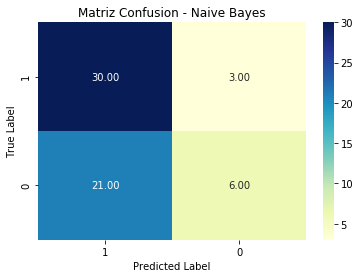

In [31]:
sns.heatmap(confusion_matrix(Test_Y,predictions_NB),annot=True, fmt=".2f", cmap="YlGnBu",#cmap="coolwarm",
            xticklabels = ["1", "0"] , yticklabels = ["1", "0"])
#sns.palplot(sns.cubehelix_palette(8))
plt.title("Matriz Confusion - Naive Bayes")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

La curva ROC del modelo, muestra que no óptimo por que se encuentra muy cerca a la linea de aleatoriedad.

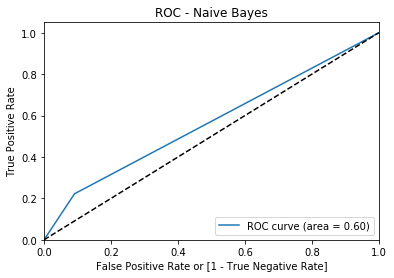

In [32]:
auc_score_nb = accuracy_score(predictions_NB, Test_Y)
fpr, tpr, thresholds = metrics.roc_curve(Test_Y,predictions_NB, 
                                         drop_intermediate= False)
plt.plot(fpr, tpr , label = 'ROC curve (area = %0.2f)' % auc_score_nb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC - Naive Bayes')
plt.legend(loc="lower right")
plt.show()

#### Dataset Word Net Lemmatizer

In [33]:
model_Naive = naive_bayes.MultinomialNB()
model_Naive.fit(Train_X_TfidfWN,Train_Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [35]:
# Se generan las predicciones
predictions_NB = model_Naive.predict(Test_X_TfidfWN)

El modelo de Naive Bayes con el dataset de Word Net Lemmatizer es mejor que el modelo anterior por que tiene un accuracy de 70%.

In [36]:
# Y se obtiene la precisión del modelo 
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(Test_Y,predictions_NB))

Naive Bayes Accuracy Score ->  70.0
Naive Bayes Confusion Matrix:
[[30  3]
 [15 12]]


La matriz de confusión del modelo solo tiene 18 casos incorrectos a diferencia de los 24 casos incorrectos del Naive Bayes SnowBall Stemmer.

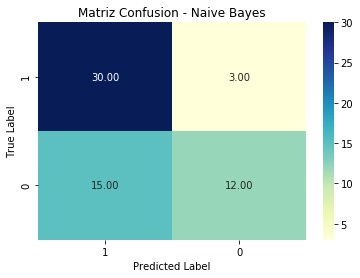

In [37]:
sns.heatmap(confusion_matrix(Test_Y,predictions_NB),annot=True, fmt=".2f", cmap="YlGnBu",#cmap="coolwarm",
            xticklabels = ["1", "0"] , yticklabels = ["1", "0"])
#sns.palplot(sns.cubehelix_palette(8))
plt.title("Matriz Confusion - Naive Bayes")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

La curva ROC de este modelo es mejor que el del SnowBall Stemmer.

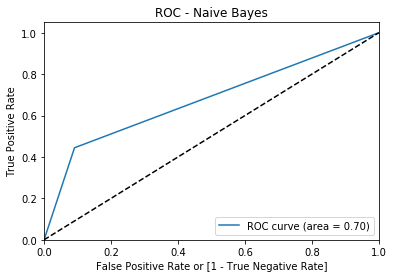

In [38]:
auc_score_nb = accuracy_score(predictions_NB, Test_Y)
fpr, tpr, thresholds = metrics.roc_curve(Test_Y,predictions_NB, 
                                         drop_intermediate= False)
plt.plot(fpr, tpr , label = 'ROC curve (area = %0.2f)' % auc_score_nb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC - Naive Bayes')
plt.legend(loc="lower right")
plt.show()

### Modelo SVM
El modelo Support Vector Machines representa los elementos como puntos en un espacio y comienza la busqueda de un hiperplano que los separe y clasifique adecuadamente.
Las desventajas que tiene son de que se basa en dos ejes o dos variables predictoras y que la realidad de algunos datos es que no se separan por una función lineal.

#### Dataset SnowBall Stemmer

In [39]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_TfidfSB,Train_Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [40]:
predictions_SVM = SVM.predict(Test_X_TfidfSB)

El primer modelo SVM con el dataset de SnowBall obtiene un 68.3%, mejor que el modelo de Naive Bayes del SnowBall; sin embargo, es menor al modelo Naive Bayes del dataset WordNet Lemmatizer.

In [41]:
# Y se obtiene la precisión del modelo 
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
print("SVM Matrix:")
print(confusion_matrix(Test_Y,predictions_SVM))

SVM Accuracy Score ->  68.33333333333333
SVM Matrix:
[[29  4]
 [15 12]]


La matriz de confusión muestra unos 19 casos incorrectos.

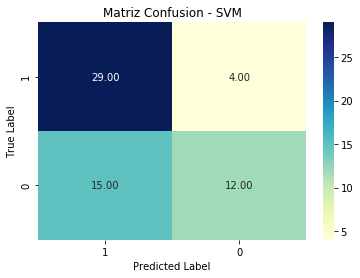

In [42]:
sns.heatmap(confusion_matrix(Test_Y,predictions_SVM),annot=True, fmt=".2f", cmap="YlGnBu",#cmap="coolwarm",
            xticklabels = ["1", "0"] , yticklabels = ["1", "0"])
#sns.palplot(sns.cubehelix_palette(8))
plt.title("Matriz Confusion - SVM")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

La curva ROC muestra un mejor desempeño que el modelo Naive Bayes de Snowball Stemmer.

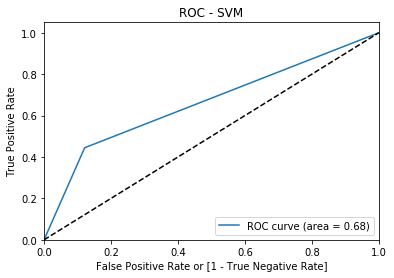

In [43]:
auc_score_svm = accuracy_score(predictions_SVM, Test_Y)
fpr, tpr, thresholds = metrics.roc_curve(Test_Y,predictions_SVM, 
                                         drop_intermediate= False)
plt.plot(fpr, tpr , label = 'ROC curve (area = %0.2f)' % auc_score_svm)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC - SVM')
plt.legend(loc="lower right")
plt.show()

Otra manera de mejorar el desempeño del modelo entrenado es en base a la estimación de hiperparametros. En este caso, utilice la función de Search Grid basado en el metodo de Cross Validation. Se crea un diccionario con los diferentes parametros que entrenara el modelo SVM y mediante el validación cruzada de los dataset evaluará cada modelo, hasta obtener el mejor modelo.

In [45]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,'auto'], 
              'kernel': ['rbf','poly','sigmoid','linear']}

In [46]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

In [47]:
# fitting the model for grid search 
grid.fit(Train_X_TfidfSB, Train_Y) 

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .

[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=poly ..................................
[CV] ...... C=0.1, gamma=auto, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=poly ..................................
[CV] ...... C=0.1, gamma=auto, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=poly ..................................
[CV] ...... C=0.1, gamma=auto, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=poly ..................................
[CV] ...... C=0.1, gamma=auto, kernel=poly, score=0.536, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=poly ..................................
[CV] ...... C=0.1, gamma=auto, kernel=poly, score=0.536, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=sigmoid ...............................
[CV] .

[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.679, total=   0.0s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.714, total=   0.0s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.500, total=   0.0s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.643, total=   0.0s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.679, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=1, kernel=linear, score=0.750, total=   0.0s
[CV] C=10, gamma=1, kernel=linear ....................................
[CV] ........ C=10, gamma=1, kernel=linear, score=0.571, total=   0.0s
[CV] C=10, gamma=1, kernel=linear ....................................
[CV] ........ C=10, gamma=1, kernel=linear, score=0.607, total=   0.0s
[CV] C=10, gamma=1, kernel=linear ....................................
[CV] ........ C=10, gamma=1, kernel=linear, score=0.714, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.679, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.750, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] .

[CV] ... C=10, gamma=0.0001, kernel=linear, score=0.679, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] ... C=10, gamma=0.0001, kernel=linear, score=0.750, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] ... C=10, gamma=0.0001, kernel=linear, score=0.571, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] ... C=10, gamma=0.0001, kernel=linear, score=0.607, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] ... C=10, gamma=0.0001, kernel=linear, score=0.714, total=   0.0s
[CV] C=10, gamma=auto, kernel=rbf ....................................
[CV] ........ C=10, gamma=auto, kernel=rbf, score=0.571, total=   0.0s
[CV] C=10, gamma=auto, kernel=rbf ....................................
[CV] ........ C=10, gamma=auto, kernel=rbf, score=0.571, total=   0.0s
[CV] C=10, gamma=auto, kernel=rbf ....................................
[CV] .

[CV] .... C=100, gamma=0.01, kernel=linear, score=0.679, total=   0.0s
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] .... C=100, gamma=0.01, kernel=linear, score=0.750, total=   0.0s
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] .... C=100, gamma=0.01, kernel=linear, score=0.571, total=   0.0s
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] .... C=100, gamma=0.01, kernel=linear, score=0.607, total=   0.0s
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] .... C=100, gamma=0.01, kernel=linear, score=0.714, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] .

[CV] ..... C=1000, gamma=1, kernel=sigmoid, score=0.607, total=   0.0s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.679, total=   0.0s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.750, total=   0.0s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.571, total=   0.0s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.607, total=   0.0s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.714, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.679, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] .

[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.750, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.571, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.607, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.714, total=   0.0s
[CV] C=1000, gamma=auto, kernel=rbf ..................................
[CV] ...... C=1000, gamma=auto, kernel=rbf, score=0.679, total=   0.0s
[CV] C=1000, gamma=auto, kernel=rbf ..................................
[CV] ...... C=1000, gamma=auto, kernel=rbf, score=0.750, total=   0.0s
[CV] C=1000, gamma=auto, kernel=rbf ..................................
[CV] ...... C=1000, gamma=auto, kernel=rbf, score=0.500, total=   0.0s
[CV] C=1000, gamma=auto, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.2s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [48]:
grid_predictions = grid.predict(Test_X_TfidfSB) 

El mejor modelo obtiene 70% de accuracy y con 18 casos incorrectos para el dataset de evaluación mediante el método Snowball.

In [49]:
# Y se obtiene la precisión del modelo 
print("SVM Accuracy Score -> ",accuracy_score(grid_predictions, Test_Y)*100)
print("SVM Matrix:")
print(confusion_matrix(Test_Y,grid_predictions))

SVM Accuracy Score ->  70.0
SVM Matrix:
[[28  5]
 [13 14]]


#### Dataset Word Net Lemmatizer

In [50]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_TfidfWN,Train_Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [51]:
predictions_SVM = SVM.predict(Test_X_TfidfWN)

El modelo SVM con los elementos transformados con WordNet Lemmatizer obtiene un accuracy del 72% con 17 casos clasificados incorrectamente.

In [52]:
# Y se obtiene la precisión del modelo 
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
print("SVM Matrix:")
print(confusion_matrix(Test_Y,predictions_SVM))

SVM Accuracy Score ->  71.66666666666667
SVM Matrix:
[[29  4]
 [13 14]]


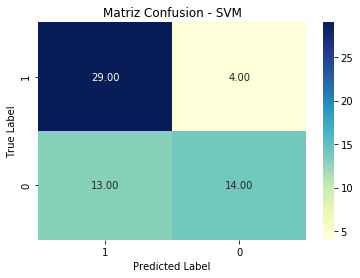

In [53]:
sns.heatmap(confusion_matrix(Test_Y,predictions_SVM),annot=True, fmt=".2f", cmap="YlGnBu",#cmap="coolwarm",
            xticklabels = ["1", "0"] , yticklabels = ["1", "0"])
#sns.palplot(sns.cubehelix_palette(8))
plt.title("Matriz Confusion - SVM")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

La curva ROC muestra un mejor desempeño.

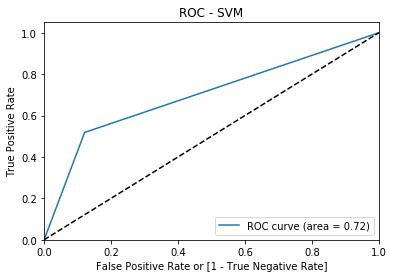

In [54]:
auc_score_svm = accuracy_score(predictions_SVM, Test_Y)
fpr, tpr, thresholds = metrics.roc_curve(Test_Y,predictions_SVM, 
                                         drop_intermediate= False)
plt.plot(fpr, tpr , label = 'ROC curve (area = %0.2f)' % auc_score_svm)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC - SVM')
plt.legend(loc="lower right")
plt.show()

In [45]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,'auto'], 
              'kernel': ['rbf','poly','sigmoid','linear']}

In [46]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

In [55]:
# fitting the model for grid search 
grid.fit(Train_X_TfidfWN, Train_Y) 

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .

[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=poly ..................................
[CV] ...... C=0.1, gamma=auto, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=poly ..................................
[CV] ...... C=0.1, gamma=auto, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=poly ..................................
[CV] .

[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.536, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.536, total=   0.0s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] ....... C=1, gamma=0.001, kernel=poly, score=0.571, total=   0.0s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] ....... C=1, gamma=0.001, kernel=poly, score=0.571, total=   0.0s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] ....... C=1, gamma=0.001, kernel=poly, score=0.571, total=   0.0s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] .

[CV] ........ C=10, gamma=1, kernel=linear, score=0.679, total=   0.0s
[CV] C=10, gamma=1, kernel=linear ....................................
[CV] ........ C=10, gamma=1, kernel=linear, score=0.643, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.679, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.643, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.679, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.643, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] .

[CV] .. C=10, gamma=0.0001, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=sigmoid ..............................
[CV] .. C=10, gamma=0.0001, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=sigmoid ..............................
[CV] .. C=10, gamma=0.0001, kernel=sigmoid, score=0.536, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=sigmoid ..............................
[CV] .. C=10, gamma=0.0001, kernel=sigmoid, score=0.536, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] ... C=10, gamma=0.0001, kernel=linear, score=0.679, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] ... C=10, gamma=0.0001, kernel=linear, score=0.643, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] ... C=10, gamma=0.0001, kernel=linear, score=0.536, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] .

[CV] ...... C=100, gamma=0.01, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=0.01, kernel=poly ..................................
[CV] ...... C=100, gamma=0.01, kernel=poly, score=0.536, total=   0.0s
[CV] C=100, gamma=0.01, kernel=poly ..................................
[CV] ...... C=100, gamma=0.01, kernel=poly, score=0.536, total=   0.0s
[CV] C=100, gamma=0.01, kernel=sigmoid ...............................
[CV] ... C=100, gamma=0.01, kernel=sigmoid, score=0.714, total=   0.0s
[CV] C=100, gamma=0.01, kernel=sigmoid ...............................
[CV] ... C=100, gamma=0.01, kernel=sigmoid, score=0.679, total=   0.0s
[CV] C=100, gamma=0.01, kernel=sigmoid ...............................
[CV] ... C=100, gamma=0.01, kernel=sigmoid, score=0.607, total=   0.0s
[CV] C=100, gamma=0.01, kernel=sigmoid ...............................
[CV] ... C=100, gamma=0.01, kernel=sigmoid, score=0.607, total=   0.0s
[CV] C=100, gamma=0.01, kernel=sigmoid ...............................
[CV] .

[CV] ........ C=1000, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=1, kernel=poly ....................................
[CV] ........ C=1000, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=1, kernel=poly ....................................
[CV] ........ C=1000, gamma=1, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=1, kernel=poly ....................................
[CV] ........ C=1000, gamma=1, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=1, kernel=sigmoid .................................
[CV] ..... C=1000, gamma=1, kernel=sigmoid, score=0.607, total=   0.0s
[CV] C=1000, gamma=1, kernel=sigmoid .................................
[CV] ..... C=1000, gamma=1, kernel=sigmoid, score=0.607, total=   0.0s
[CV] C=1000, gamma=1, kernel=sigmoid .................................
[CV] ..... C=1000, gamma=1, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=1000, gamma=1, kernel=sigmoid .................................
[CV] .

[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.536, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=poly ...............................
[CV] ... C=1000, gamma=0.0001, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=poly ...............................
[CV] ... C=1000, gamma=0.0001, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=poly ...............................
[CV] ... C=1000, gamma=0.0001, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=poly ...............................
[CV] ... C=1000, gamma=0.0001, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=poly ...............................
[CV] ... C=1000, gamma=0.0001, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=sigmoid ............................
[CV]  C=1000, gamma=0.0001, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=sigmoid ............................
[CV]  

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [57]:
grid_predictions = grid.predict(Test_X_TfidfWN) 

Realizando la busqueda de un mejor modelo con el SearchGrid, se obtiene un accuracy igual al modelo anterior de 71.6% y con los 17 casos incorrectos.

In [58]:
# Y se obtiene la precisión del modelo 
print("SVM Accuracy Score -> ",accuracy_score(grid_predictions, Test_Y)*100)
print("SVM Matrix:")
print(confusion_matrix(Test_Y,grid_predictions))

SVM Accuracy Score ->  71.66666666666667
SVM Matrix:
[[29  4]
 [13 14]]


## Resultados
El modelo con mejor accuracy es el de SVM con los datos transformados mediante WordNet Lemmatizer. Considere el Snowball Stemmer por que muestra mejor reducción de formas canónicas de los documentos en español que WordNet Lemmatizer; sin embargo, después de realizar la práctica, compruebó que su reducción permite a los modelos trabajar de forma más precisa que el otro metodo.
Sin embargo, creo que se podría revisar con otros tipos de modelo como árboles de decisión, modelos de máxima entropía o modelos ensamblados.